In [1]:
import librosa
import glob
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import Audio
from librosa.display import specshow

In [2]:
# bajo y descomprimo archivo
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
!mkdir speechcommands
!tar -xf speech_commands_v0.01.tar.gz -C /content/speechcommands

--2020-07-10 15:17:22--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.217.204.128, 2607:f8b0:400c:c15::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.217.204.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   161MB/s    in 12s     

2020-07-10 15:17:34 (119 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [3]:
# usando glob, armo las listas con los numeros a entrenar
# del 0 al 9
zero_wavs = glob.glob('speechcommands/zero/*.wav')
one_wavs = glob.glob('speechcommands/one/*.wav')
two_wavs = glob.glob('speechcommands/two/*.wav')
three_wavs = glob.glob('speechcommands/three/*.wav')
four_wavs = glob.glob('speechcommands/four/*.wav')
five_wavs = glob.glob('speechcommands/five/*.wav')
six_wavs = glob.glob('speechcommands/six/*.wav')
seven_wavs = glob.glob('speechcommands/seven/*.wav')
eight_wavs = glob.glob('speechcommands/eight/*.wav')
nine_wavs = glob.glob('speechcommands/nine/*.wav')


In [4]:
zero_wavs[0:5]
#zero_wavs

['speechcommands/zero/8dd788d8_nohash_1.wav',
 'speechcommands/zero/6021f08b_nohash_0.wav',
 'speechcommands/zero/5aac2efa_nohash_0.wav',
 'speechcommands/zero/5236848b_nohash_3.wav',
 'speechcommands/zero/90b0b91a_nohash_1.wav']

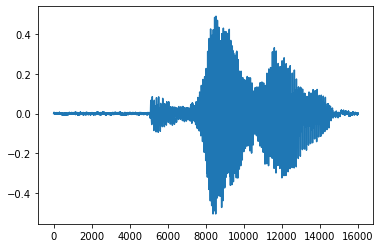

In [5]:
#abrimos uno de los audios para ver su contenido
# y lo graficamos
# esto es a modo de prueba
x,sr = librosa.core.load(zero_wavs[15],sr=None)
plt.plot(x)

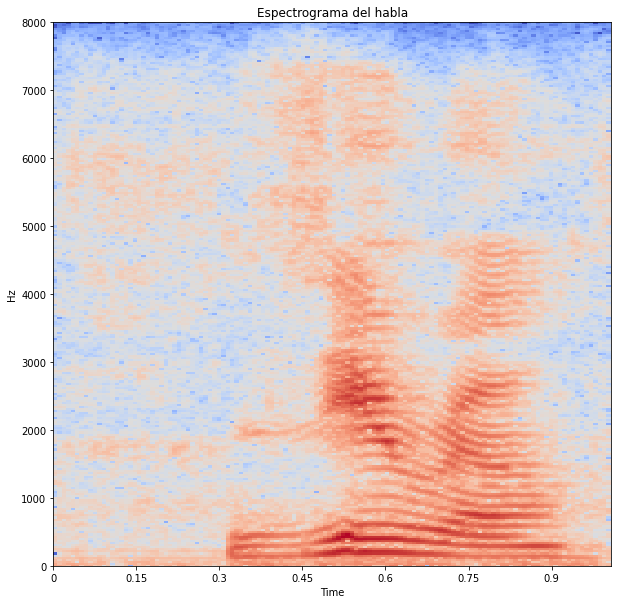

In [6]:
winsize=512
hopsize=128

# espectograma y reduccion de atributos

spectrogram = librosa.stft(x,n_fft=winsize,hop_length=hopsize,win_length=winsize)
mag_spectrogram = np.abs(spectrogram)

plt.figure(figsize=(10,10))
plt.title('Espectrograma del habla')
specshow(10*np.log10(mag_spectrogram),sr=16000,hop_length=hopsize,y_axis='linear',x_axis='time',vmin=-50)
Audio(x,rate=16000)


In [7]:
# esta funcion es la que nos va a reducir las dimensiones de los archivos, nos quedan 78 atributos
# Para poder "agrupar" energías de frecuencias cercanas utilizamos la escala Mel
# Reduzco la dimensionalidad entonces utlizando los MFCCs 

def calculate_features(filename, n_mfcc=12,delta=True,deltadelta=True,energy=True, summary_fn = [np.mean, np.std], summary_names=['mean','std']):
  #Abro el archivo:
  x, sr = librosa.core.load(filename,sr=None)
  
  #Calculo MFCCs
  features = librosa.feature.mfcc(x,sr=sr,n_mfcc=n_mfcc)
  feat_names = ['mfcc_{}'.format(i) for i in range(n_mfcc)]
  #Calculo energia:
  if energy:
    energy = librosa.feature.rmse(x)
    features = np.concatenate([features,energy])
    feat_names = feat_names + ['energy']
  #Aplico media y desvio estandar por defecto
  summary_features = np.concatenate([fn(features,axis=1) for fn in summary_fn])
  feat_names = ['{}_{}'.format(name_i,summ_i) for summ_i in summary_names for name_i in feat_names]
  
  #Lo mismo con los delta
  if delta:
    deltafeatures = np.diff(features)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltafeatures,axis=1) for fn in summary_fn])])
    d_names = ['d{}'.format(name) for name in feat_names]
  else:
    d_names = []

  #Y con los delta de segundo orden
  if deltadelta:
    deltadeltafeatures = np.diff(features,n=2)
    summary_features = np.concatenate([summary_features,np.concatenate([fn(deltadeltafeatures,axis=1) for fn in summary_fn])]) 
    dd_names = ['dd{}'.format(name) for name in feat_names]
  else:
    dd_names = []

  feat_names = feat_names + d_names + dd_names
  
  return summary_features, feat_names  

In [ ]:
# ejempplo de calculo de features para un archivo
feat, names = calculate_features(one_wavs[5])

len(feat) # me quedan 78 atributos

78

In [8]:
import numpy as np
import pickle
import re

# armo un array con las 10 listas para recorrerlo

vec_num=[['zero',zero_wavs],
         ['one',one_wavs],
         ['two',two_wavs], 
         ['three',three_wavs],
         ['four',four_wavs],
         ['five', five_wavs], 
         ['six', six_wavs],
         ['seven',seven_wavs],
         ['eight',eight_wavs],
         ['nine',nine_wavs]]


In [9]:
import pandas as pd

df_all=pd.DataFrame()

for numero in vec_num:
  
  print(numero[0])

  for arch in numero[1]:
    
    # calculo los features del archivo
    feat, names = calculate_features(arch, delta=False, deltadelta=False) # hago esta Modificacion y pongo la 1ra y 2da derivada como falsa

    # armo dataframe con los features y los nombres de columnas
    df=pd.DataFrame(feat,index=names).transpose()

    # busco la posicion del primer /
    pos=arch.find('/')

    # agrego los atributos que faltan
    df['target']= numero[0]
    df['file'] = arch[pos+1:]
    df['group']= 'train_modif2' # es un grupo nuevo
 
    # busco si esta en validation list
    with open('speechcommands/validation_list.txt','r') as f:
      texto = f.read()
 
    matches = re.findall(arch[pos+1:], texto)
    if (len(matches) >0):
      df['group']='validation_modif2' # es un grupo nuevo

    # busco si esta en testing list
    with open('speechcommands/testing_list.txt','r') as f:
      texto = f.read()
 
    matches = re.findall(arch[pos+1:], texto)
    if (len(matches) >0):
      df['group']='testing_modif2' # es un grupo nuevo
    
    # concateno los dataframe para armar el dataframe final
    df_all=pd.concat([df_all,df])

  print(numero[0])

# resultado
df_all.head()


zero
zero
one
one
two
two
three
three
four
four
five
five
six
six
seven
seven
eight
eight
nine
nine


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,target,file,group
0,-310.373780,108.100260,-35.916181,33.898475,-30.267377,21.804664,-8.092194,3.688589,-27.701459,14.652777,-12.138142,6.300064,0.031405,108.335783,39.959982,37.495254,25.414830,24.366416,9.490059,13.301543,18.480796,21.117286,10.857483,19.095641,8.229837,0.030842,zero,zero/8dd788d8_nohash_1.wav,train_modif2
0,-268.940979,109.094888,18.249464,39.821188,27.161642,26.775130,-2.063644,13.449217,-2.512277,17.021364,0.485951,6.682188,0.076727,96.166463,30.126237,43.767123,17.850829,16.963540,16.508826,21.946652,16.439935,9.671001,9.597063,5.873054,7.696213,0.040160,zero,zero/6021f08b_nohash_0.wav,testing_modif2
0,-162.838334,89.749041,-11.773584,-5.650079,-21.146136,-21.872953,-24.375052,-16.363518,-14.993416,-7.609461,-5.995101,-3.803240,0.284765,152.889283,50.146729,51.632548,30.596622,27.040773,18.821318,14.214723,8.142725,13.274695,10.120220,20.488937,10.556037,0.198115,zero,zero/5aac2efa_nohash_0.wav,train_modif2
0,-311.809058,77.403861,-39.393476,7.104459,-11.155193,2.627961,-22.229770,-17.583034,-1.142070,-4.427150,-3.725588,2.602168,0.072842,148.300601,55.231457,59.282381,41.064272,25.052952,13.858085,34.307361,23.183467,15.329263,15.736575,10.908234,6.403918,0.081364,zero,zero/5236848b_nohash_3.wav,train_modif2
0,-441.658706,82.740887,-16.495500,8.089898,-25.552193,-17.319364,-22.009776,-19.578614,-17.590691,-7.017059,-21.428044,-17.133335,0.038358,196.571589,66.848065,87.437274,35.118191,33.694765,23.893936,26.446429,19.518883,20.786852,11.838037,15.728746,16.071462,0.037518,zero,zero/90b0b91a_nohash_1.wav,train_modif2


In [10]:
print(df_all.shape) 
# en este caso tengo 29 atributos. Sacando Target, file y Group tengo 26
# antes tenia 81 atributos. Sacando Target, file y Group teniamos 78
df_all= df_all.reset_index(drop=True)
df_all.tail()


(23666, 29)


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,target,file,group
23661,-415.430049,107.282307,-13.054556,9.917492,-7.596625,32.744440,6.045337,5.661100,4.597910,-7.489571,-25.887736,0.124294,0.022510,126.786810,53.878620,27.407322,31.001210,21.268574,9.636542,23.638855,23.350247,8.416431,14.970623,20.655259,16.613088,0.020840,nine,nine/d6360b32_nohash_0.wav,train_modif2
23662,-151.655249,89.670530,-44.768472,21.289442,-9.168274,-13.403113,-14.786645,0.553648,-12.705081,0.213594,-12.476978,5.631764,0.096245,87.789904,25.422293,36.955263,31.280857,16.130491,11.211964,4.844609,13.474585,9.766098,14.605206,7.674664,8.067169,0.102322,nine,nine/aa62fdad_nohash_0.wav,train_modif2
23663,-341.458072,116.153615,-8.776219,22.852137,9.872183,-5.371321,-18.267232,0.309461,-10.583217,-1.390698,-23.471486,1.993296,0.034170,121.629210,24.105517,28.664440,22.689190,9.149027,12.941140,11.555464,11.358058,9.164017,10.553355,14.550235,7.522420,0.032925,nine,nine/99b05bcf_nohash_0.wav,train_modif2
23664,-416.408413,114.077955,26.367215,13.725987,3.133741,-9.188315,0.619676,-13.512508,5.421413,1.619313,3.488362,1.299350,0.043540,171.138900,44.803640,37.303090,21.116300,21.756082,19.429638,13.840582,19.732260,9.298322,10.067368,5.635346,8.995373,0.043266,nine,nine/be7a5b2d_nohash_4.wav,train_modif2
23665,-424.175223,114.316835,0.582293,11.389763,14.643721,19.090539,-11.624597,20.370452,-10.538238,5.564677,0.420213,-7.469144,0.024655,161.286535,35.790445,21.072649,25.163348,25.999231,13.936727,20.722264,13.556298,14.655523,10.217195,8.216761,10.795978,0.021378,nine,nine/063d48cf_nohash_1.wav,train_modif2


In [11]:
# aux
len(eight_wavs)

2352

In [12]:
# debe coincidir la suma de los largos de las listas con las filas del dataframe final
# antes eran 81 atributos: 78 de los wavs + target + file + group
# ahora son 29 atributos: 26 d los wavs + target + file + group
suma_total=len(zero_wavs)+len(one_wavs)+len(two_wavs)+len(three_wavs)+len(four_wavs)+len(five_wavs)+len(six_wavs)+len(seven_wavs)+len(eight_wavs)+len(nine_wavs)

print(suma_total)
print(df_all.shape)


23666
(23666, 29)


In [16]:
# grabo archivo pickle
pickle.dump( df_all, open( "feat_numbers_modif2.p", "wb" ) )

In [14]:
# pruebo levantar el archivo
df_feat = pickle.load( open( "feat_numbers_modif2.p", "rb" ) )
print(df_feat.shape)
df_feat.head(10)


(23666, 29)


,mfcc_0_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean,mfcc_11_mean,energy_mean,mfcc_0_std,mfcc_1_std,mfcc_2_std,mfcc_3_std,mfcc_4_std,mfcc_5_std,mfcc_6_std,mfcc_7_std,mfcc_8_std,mfcc_9_std,mfcc_10_std,mfcc_11_std,energy_std,target,file,group
0,-310.373780,108.100260,-35.916181,33.898475,-30.267377,21.804664,-8.092194,3.688589,-27.701459,14.652777,-12.138142,6.300064,0.031405,108.335783,39.959982,37.495254,25.414830,24.366416,9.490059,13.301543,18.480796,21.117286,10.857483,19.095641,8.229837,0.030842,zero,zero/8dd788d8_nohash_1.wav,train_modif2
1,-268.940979,109.094888,18.249464,39.821188,27.161642,26.775130,-2.063644,13.449217,-2.512277,17.021364,0.485951,6.682188,0.076727,96.166463,30.126237,43.767123,17.850829,16.963540,16.508826,21.946652,16.439935,9.671001,9.597063,5.873054,7.696213,0.040160,zero,zero/6021f08b_nohash_0.wav,testing_modif2
2,-162.838334,89.749041,-11.773584,-5.650079,-21.146136,-21.872953,-24.375052,-16.363518,-14.993416,-7.609461,-5.995101,-3.803240,0.284765,152.889283,50.146729,51.632548,30.596622,27.040773,18.821318,14.214723,8.142725,13.274695,10.120220,20.488937,10.556037,0.198115,zero,zero/5aac2efa_nohash_0.wav,train_modif2
3,-311.809058,77.403861,-39.393476,7.104459,-11.155193,2.627961,-22.229770,-17.583034,-1.142070,-4.427150,-3.725588,2.602168,0.072842,148.300601,55.231457,59.282381,41.064272,25.052952,13.858085,34.307361,23.183467,15.329263,15.736575,10.908234,6.403918,0.081364,zero,zero/5236848b_nohash_3.wav,train_modif2
4,-441.658706,82.740887,-16.495500,8.089898,-25.552193,-17.319364,-22.009776,-19.578614,-17.590691,-7.017059,-21.428044,-17.133335,0.038358,196.571589,66.848065,87.437274,35.118191,33.694765,23.893936,26.446429,19.518883,20.786852,11.838037,15.728746,16.071462,0.037518,zero,zero/90b0b91a_nohash_1.wav,train_modif2
5,-294.065002,63.769191,2.440345,46.773668,-16.516617,18.061337,-21.688244,8.705834,-17.671885,7.331514,-4.832365,2.760931,0.053753,106.013091,54.118975,52.618458,35.192636,19.895059,19.837400,22.999047,18.240496,18.693545,13.708766,9.862899,10.822629,0.044808,zero,zero/a1a59b72_nohash_1.wav,train_modif2
6,-441.738988,108.598029,11.615961,37.673278,-7.745203,28.137951,-1.688316,7.181629,-2.181470,-2.004422,-6.347100,10.214135,0.010853,123.403187,68.990583,50.024546,28.640536,18.747211,15.994819,18.204183,23.822331,8.803666,8.939778,10.840528,9.897410,0.007374,zero,zero/4beff0c5_nohash_1.wav,train_modif2
7,-500.754130,106.737902,10.025035,30.244682,11.062777,7.924430,-4.503631,8.243450,-9.932466,6.755975,2.319555,4.455084,0.006111,118.438123,62.132773,40.761139,20.772084,15.119337,18.504008,14.540343,11.310144,13.271344,10.234326,7.679819,7.665914,0.006047,zero,zero/7b301939_nohash_0.wav,train_modif2
8,-409.402968,54.259014,34.806781,29.927235,6.793169,13.010912,-4.265431,1.289623,-6.347857,-0.127901,-4.044471,4.673592,0.024136,47.030496,34.740323,28.960487,16.655429,8.206547,9.137766,10.185044,8.771067,11.219946,9.664843,7.874695,8.185257,0.036853,zero,zero/46a153d8_nohash_2.wav,train_modif2
9,-369.264751,47.742707,-19.100869,16.722791,-11.539022,1.596489,-21.301765,4.031664,-15.983343,5.479910,-3.988212,-2.038888,0.021624,121.232160,41.450991,48.461800,20.020086,15.840558,11.561626,21.415755,10.774701,9.993867,8.845553,7.815317,6.942792,0.024541,zero,zero/5ab63b0a_nohash_0.wav,train_modif2


In [15]:
# Cuantos tengo en cada uno de los grupos
df_feat.group.value_counts()

train_modif2         18620
testing_modif2        2552
validation_modif2     2494
Name: group, dtype: int64

El arhivo feat_numbers_modif1.p en la carpeta content-speechcommands lo guardo manualmente desde el collab y lo subo al Github.

Despues lo corro directamente en el modelo (una copia)